In [23]:
import sys
base_dir = "D:/Thesis/Cobra/cobra/"
if base_dir not in sys.path:
    sys.path.append(base_dir)
from os.path import join
import pandas as pd
from utilities import basic, utils, mri_stats, stats
from stats_tools import vis as svis
import numpy as np
import seaborn as sns
from access_sif_data import load_data_tools as ld
import matplotlib.pyplot as plt
from datetime import datetime as dt
%matplotlib inline
plt.rcParams["figure.dpi"] = 40
plt.style.use('ggplot')
import importlib
importlib.reload(utils)

<module 'utilities.utils' from 'D:/Thesis/Cobra/cobra\\utilities\\utils.py'>

In [91]:
fig_dir = join(base_dir, 'figs')
table_dir = join(base_dir, 'data/tables')
dfc = utils.load_scan_csv(join(table_dir, 'neg_pos_clean.csv'))

C:\Users\klein\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  This is separate from the ipykernel package so we can avoid doing imports until


In [98]:
# Lists of relevant patients
ls_t1_pp = np.loadtxt("D:\Thesis\Cobra\cobra\data\patient_groups\\t1_pre_post.txt", dtype=str)
ls_t1_post = np.loadtxt("D:\Thesis\Cobra\cobra\data\patient_groups\\t1_post.txt", dtype=str)
#ls_t1_pos = np.loadtxt("D:\Thesis\Cobra\cobra\data\patient_groups\\t1_pos.txt", dtype=str)
ls_t1_neg = np.loadtxt("D:\Thesis\Cobra\cobra\data\patient_groups\\t1_neg.txt", dtype=str)
ls_t1_ppp = list(set(ls_t1_pp).union(set(ls_t1_post)))

In [13]:
df_t1_all = dfc[dfc.Sequence=='t1']
df_pp = dfc[(dfc.PatientID.isin(ls_t1_pp)) & (dfc.Sequence=='t1')]
df_post = dfc[(dfc.PatientID.isin(ls_t1_post)) & (dfc.Sequence=='t1')]

# Merge number of slices df with dfc and save

In [106]:
#present_ids = dfc[~dfc.NumberOfSlices.isna()].SeriesInstanceUID.unique()
#df_flair_missing = df_flair_all[~df_flair_all.SeriesInstanceUID.isin(present_ids)]

In [ ]:
#utils.save_nscans_to_txt(df_flair_missing, 
#        f"{base_dir}/data/temp/flair_n_slices.txt", 'Y:', 'G:\\')

In [ ]:
#df_flair_nos = pd.read_csv(f"{base_dir}/data/temp/flair_n_slices.txt", header=None, 
#    names=['SeriesInstanceUID','NumberOfSlices'])

In [101]:
#df_all = pd.read_csv(join(table_dir, 't1','all.csv'), index_col=0)
#dfc = pd.merge(dfc, df_all[['SeriesInstanceUID', 'NumberOfSlices']], on='SeriesInstanceUID', how='left')
#dfc = dfc.rename(columns={'xPixelSpacing':'RowSpacing','yPixelSpacing':'ColumnSpacing'})
#dfc.loc[dfc.NumberOfSlices.isna(), 'NumberOfSlices'] = dfc.merge(
#    df_flair_nos, how='left', on='SeriesInstanceUID')['NumberOfSlices_y']
#dfc.to_csv(f"{table_dir}/neg_pos_clean.csv", index=False, header=True)

# Create Box plots

## FLAIR

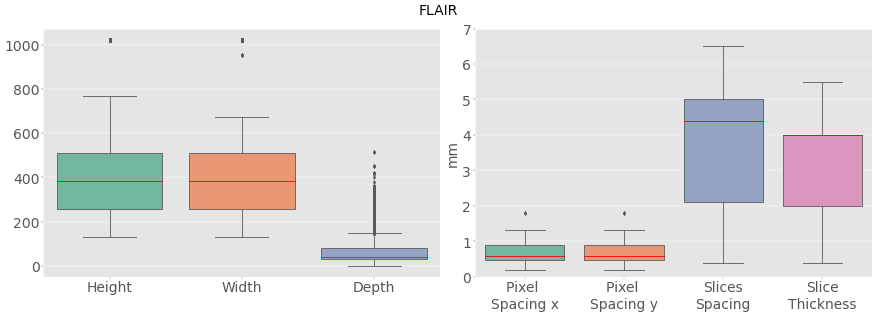

In [122]:
fig, ax = plt.subplots(1,2, figsize=(22,8))
df_flair_all = dfc[dfc.Sequence=='flair']
fig, _ = svis.create_boxplot(df_flair_all[['Rows', 'Columns', 'NumberOfSlices', ]], 
    data_labels=["Height", "Width", "Depth", ], 
    kwargs={'xlabel':'',},
    fig=fig, ax=ax[0])
svis.create_boxplot(df_flair_all[['RowSpacing', 'ColumnSpacing', 'SpacingBetweenSlices','SliceThickness' ]], 
    data_labels=["Pixel \nSpacing x", "Pixel \nSpacing y", 
                "Slices\nSpacing","Slice\nThickness" ], 
    kwargs={'xlabel':'','ylabel':'mm', 'yrange':(0,7)},
    fig=fig, ax=ax[1])
fig.suptitle("FLAIR", fontsize=25)
fig.tight_layout()
fig.savefig(join(fig_dir, 'flair', 'dimension_box_plot_flair_all.png'))

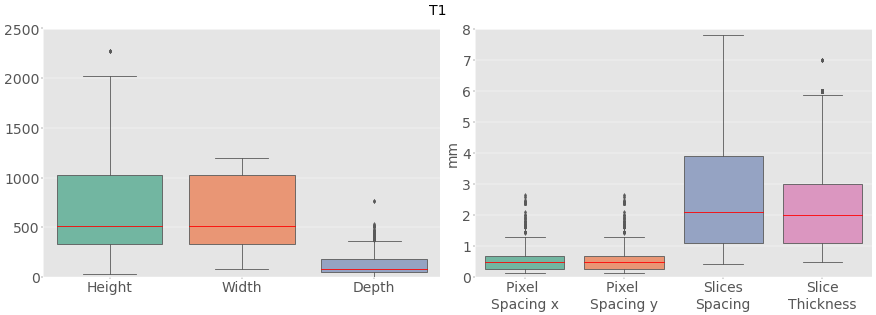

In [142]:
fig, ax = plt.subplots(1,2, figsize=(22,8))
fig, _ = svis.create_boxplot(df_t1_all[['Rows', 'Columns', 'NumberOfSlices', ]], 
    data_labels=["Height", "Width", "Depth", ], 
    kwargs={'xlabel':'','yrange':(0,2500), 'ylabel_fs':50,},
    fig=fig, ax=ax[0])
svis.create_boxplot(df_t1_all[['RowSpacing', 'ColumnSpacing', 'SpacingBetweenSlices','SliceThickness' ]], 
    data_labels=["Pixel \nSpacing x", "Pixel \nSpacing y", 
                "Slices\nSpacing","Slice\nThickness" ], 
    kwargs={'xlabel':'','ylabel':'mm', 'yrange':(0,8)},
    fig=fig, ax=ax[1])
fig.suptitle("T1", fontsize=25)
fig.tight_layout()
fig.savefig(join(fig_dir, 't1', 'dimension_box_plot_t1all.png'))

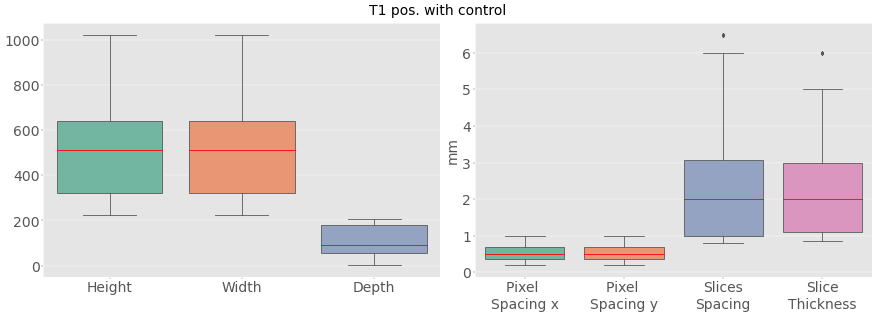

In [14]:
fig, ax = plt.subplots(1,2, figsize=(22,8))
fig, _ = svis.create_boxplot(df_pp[['Rows', 'Columns', 'NumberOfSlices', ]], 
    data_labels=["Height", "Width", "Depth", ], 
    kwargs={'xlabel':'',},
    fig=fig, ax=ax[0])
svis.create_boxplot(df_pp[['RowSpacing', 'ColumnSpacing', 'SpacingBetweenSlices','SliceThickness' ]], 
    data_labels=["Pixel \nSpacing x", "Pixel \nSpacing y",
                 "Slices\nSpacing","Slice\nThickness" ], 
    kwargs={'xlabel':'','ylabel':'mm'},
    fig=fig, ax=ax[1])
fig.suptitle("T1 pos. with control", fontsize=25)
fig.tight_layout()
fig.savefig(join(fig_dir, 't1', 'dimension_box_plot_t1pp.png'))

# Identify tumor patients

In [7]:
tumor_patient_tag = ['82f44e', '06c4453', '244a7d', '85b117f',
                        ]
tumor_patient_list = []
for tag in tumor_patient_tag:
    tumor_patient_list.append(
        dfc[dfc.PatientID.str.startswith(tag)].PatientID.unique()[0])

In [9]:
df_t1_pc = dfc[dfc.PatientID.isin(tumor_patient_list)]

In [13]:
df_t1_pc[df_t1_pc.Sequence=='t1'][['SeriesInstanceUID', 'PatientID']].to_csv(
    'D:\Thesis\Cobra\cobra\\figs\sp\T1\cancer.csv')

# Get list of t1 pos/control scans

In [189]:
arr_t1_neg = dfc[(dfc.Sequence=='t1') & (dfc.Positive==0)].PatientID.unique()
np.savetxt("D:\Thesis\Cobra\cobra\data\patient_groups\\t1_neg.txt", arr_t1_neg,
        delimiter=" ", fmt="%s")

In [190]:
arr_t1_all = dfc[dfc.Sequence=='t1'].PatientID.unique()
np.savetxt("D:\Thesis\Cobra\cobra\data\patient_groups\\t1_all.txt", arr_t1_all,
        delimiter=" ", fmt="%s")

In [10]:
ls_t1_pos = dfc[(dfc.Sequence=='t1') & (dfc.Positive==1)].PatientID.unique()
ls_t1_pos_rest = list((set(ls_t1_pos)-set(ls_t1_post))-set(ls_t1_pp))
np.savetxt("D:\Thesis\Cobra\cobra\data\patient_groups\\t1_pos_rest.txt", np.array(ls_t1_pos_rest),
    delimiter=" ", fmt="%s")

In [16]:
arr_t1_pos_rest_suid = np.array(dfc[(dfc.Sequence=='t1') & (dfc.PatientID.isin(ls_t1_pos_rest))].SeriesInstanceUID.unique())
np.savetxt("D:\Thesis\Cobra\cobra\data\patient_groups\\t1_pos_rest_suid.txt", arr_t1_pos_rest_suid,
    delimiter=" ", fmt="%s")